In [ ]:
# Disclaimer!
# I reused some code from PytorchFramework official tutorial in this notebook
# https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html

# Environment Setup

## Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dependencies

In [ ]:
# Install dependencies
!pip install kaggle pytorch-forecasting wandb -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.9/260.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.1/821.1 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Wabdb Setup

In [ ]:
# 9f8f84f94f6c54c923b27fb88197f671df0e5aab
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vvaza22 (vvaza22-free-university-of-tbilisi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics.point import MAE, CrossEntropy
from pytorch_forecasting.metrics.quantile import QuantileLoss
from lightning.pytorch.loggers import WandbLogger
import pickle
from sklearn.base import BaseEstimator, TransformerMixin

## Download Dataset

In [ ]:
FILEPATH = "/content/drive/MyDrive/ml/assignments/final"
COMPETITION = "walmart-recruiting-store-sales-forecasting"
DATA_PATH = "/content/data"

!mkdir -p ~/.kaggle
!cp {FILEPATH}/kaggle/kaggle.json ~/.kaggle/kaggle.json

!kaggle competitions download -c {COMPETITION}

!mkdir -p {DATA_PATH}
!unzip -o {COMPETITION}.zip -d {DATA_PATH}

!mkdir -p {DATA_PATH}/csv
!cp {DATA_PATH}/stores.csv {DATA_PATH}/csv/
!unzip -o {DATA_PATH}/train.csv.zip -d {DATA_PATH}/csv
!unzip -o {DATA_PATH}/features.csv.zip -d {DATA_PATH}/csv
!unzip -o {DATA_PATH}/test.csv.zip -d {DATA_PATH}/csv

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 931MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: /content/data/features.csv.zip  
  inflating: /content/data/sampleSubmission.csv.zip  
  inflating: /content/data/stores.csv  
  inflating: /content/data/test.csv.zip  
  inflating: /content/data/train.csv.zip  
Archive:  /content/data/train.csv.zip
  inflating: /content/data/csv/train.csv  
Archive:  /content/data/features.csv.zip
  inflating: /content/data/csv/features.csv  
Archive:  /content/data/test.csv.zip
  inflating: /content/data/csv/test.csv  


# Data Preparation

In [ ]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [ ]:
train_csv = pd.read_csv(f'{DATA_PATH}/csv/train.csv')
stores = pd.read_csv(f'{DATA_PATH}/csv/stores.csv')
features = pd.read_csv(f'{DATA_PATH}/csv/features.csv')

# df = pd.merge(train_csv, features, on=['Store', 'Date'], how='left')
df = pd.merge(train_csv, stores, on='Store', how='left')
# df = df.drop('IsHoliday_y', axis=1)
df.head()

Store  Dept        Date  Weekly_Sales  IsHoliday Type    Size
0      1     1  2010-02-05      24924.50      False    A  151315
1      1     1  2010-02-12      46039.49       True    A  151315
2      1     1  2010-02-19      41595.55      False    A  151315
3      1     1  2010-02-26      19403.54      False    A  151315
4      1     1  2010-03-05      21827.90      False    A  151315

In [ ]:
df.shape

(421570, 7)

## Split data

In [ ]:
SPLIT_DATE = pd.to_datetime('2011-09-01')

df['Date'] = pd.to_datetime(df['Date'])

# Train dataset
train = df[(df['Date'] < SPLIT_DATE)].copy()
train.reset_index(drop=True, inplace=True)

# Test dataset
test = df[(df['Date'] >= SPLIT_DATE)].copy()
test.reset_index(drop=True, inplace=True)

In [ ]:
train.shape

(240603, 7)

In [ ]:
test.head()

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size
0      1     1 2011-09-02      15277.27      False    A  151315
1      1     1 2011-09-09      17746.68       True    A  151315
2      1     1 2011-09-16      18535.48      False    A  151315
3      1     1 2011-09-23      17859.30      False    A  151315
4      1     1 2011-09-30      18337.68      False    A  151315

In [ ]:
# For testing code and finding bugs
traindemo = train[train['Store'] <= 5].copy()
testdemo = test[test['Store'] <= 5].copy()
traindemo.shape, testdemo.shape

((27908, 7), (20881, 7))

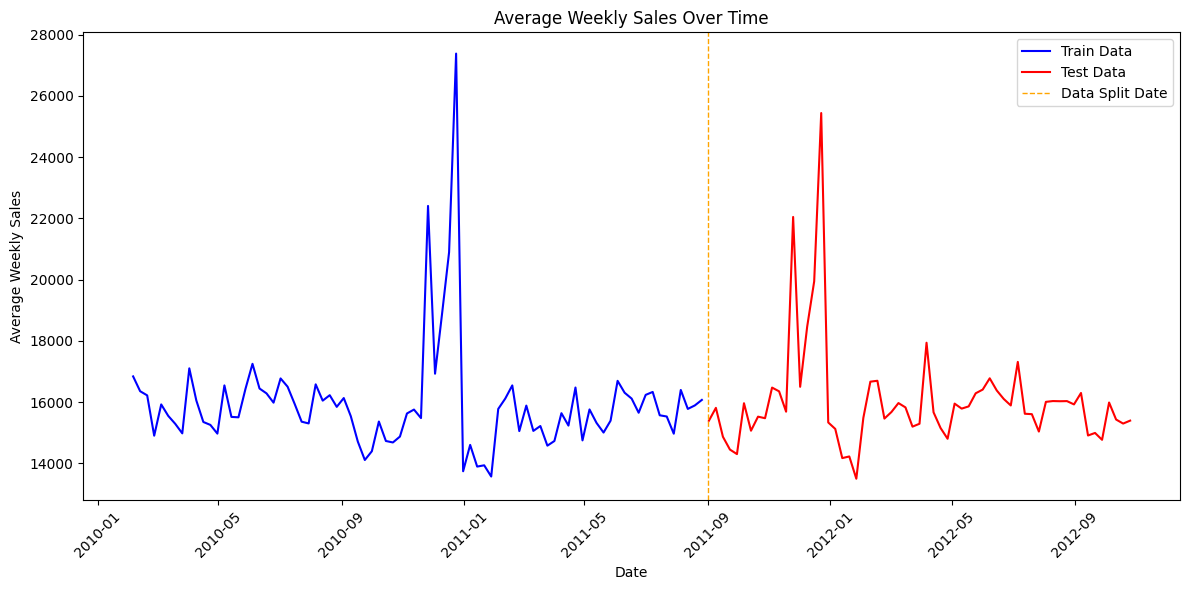

In [ ]:
plt.figure(figsize=(12, 6))

# Plot train data
avg_train_sales = train.groupby('Date')['Weekly_Sales'].mean()
plt.plot(avg_train_sales.index, avg_train_sales.values, color='blue', label='Train Data')

# Plot test data
avg_test_sales = test.groupby('Date')['Weekly_Sales'].mean()
plt.plot(avg_test_sales.index, avg_test_sales.values, color='red', label='Test Data')

# Add Split Line
plt.axvline(SPLIT_DATE, color='orange', linestyle='--', lw=1, label='Data Split Date')

plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

# Feature Engineering

In [ ]:
class ModelPipeline:
  def __init__(self, steps):
    self.steps = steps

  def transform(self, X):
    X = X.copy()
    for step in self.steps:
      X = step.transform(X)
    return X

In [ ]:
class DateToPandasDatetime:
  def transform(self, X):
    X['Date'] = pd.to_datetime(X['Date'])
    return X

In [ ]:
class HolidayToInt:
  def transform(self, X):
    X['IsHoliday'] = X['IsHoliday'].astype(int)
    return X

In [ ]:
class AddWeight:
  def transform(self, X):
    X['Weight'] = X['IsHoliday'].apply(lambda x: 5 if x else 1)
    return X

In [ ]:
class AddYearMonthDay:
  def transform(self, X):
    X['Year'] = X['Date'].dt.year
    X['Month'] = X['Date'].dt.month
    X['Day'] = X['Date'].dt.day
    return X

In [ ]:
class DateToWeekIndices:
  def transform(self, X):
    date_start = pd.to_datetime('2010-02-05')
    # Predict max 5 years into the future
    date_end = date_start + pd.DateOffset(weeks=5*52)
    date_range = pd.date_range(date_start, date_end, freq="W-FRI")
    week_indices = {date: i+1 for i, date in enumerate(date_range)}
    X['Week'] = X['Date'].map(week_indices)
    return X

In [ ]:
pipeline = ModelPipeline([
  DateToPandasDatetime(),
  HolidayToInt(),
  AddWeight(),
  DateToWeekIndices()
])

with open("pipeline.pkl", "wb") as f:
  pickle.dump(pipeline, f)

In [ ]:
with open("pipeline.pkl", "rb") as f:
  pipeline_pkl = pickle.load(f)

pipeline_pkl.transform(train)

Store  Dept       Date  Weekly_Sales  IsHoliday Type    Size  Weight  \
0           1     1 2010-02-05      24924.50          0    A  151315       1   
1           1     1 2010-02-12      46039.49          1    A  151315       5   
2           1     1 2010-02-19      41595.55          0    A  151315       1   
3           1     1 2010-02-26      19403.54          0    A  151315       1   
4           1     1 2010-03-05      21827.90          0    A  151315       1   
...       ...   ...        ...           ...        ...  ...     ...     ...   
240598     45    98 2011-07-29        599.03          0    B  118221       1   
240599     45    98 2011-08-05        982.60          0    B  118221       1   
240600     45    98 2011-08-12        827.40          0    B  118221       1   
240601     45    98 2011-08-19        535.68          0    B  118221       1   
240602     45    98 2011-08-26        385.96          0    B  118221       1   

        Week  
0          1  
1          2  
2          3  
3          4  
4          5  
...      ...  
240598    78  
240599    79  
240600    80  
240601    81  
240602    82  

[240603 rows x 9 columns]

In [ ]:
train['Type'].isna().sum(), train['Size'].isna().sum()

(np.int64(0), np.int64(0))

In [ ]:
len_dict = {}

un = train[["Store", "Dept"]].drop_duplicates().to_numpy()
for [store, dept] in un:
  df = train[(train['Store'] == store) & (train['Dept'] == dept)]
  if not df.shape[0] in len_dict:
    len_dict[df.shape[0]] = 0
  len_dict[df.shape[0]] += 1


In [ ]:
len_dict

{82: 2693,
 61: 12,
 48: 7,
 14: 2,
 66: 5,
 33: 4,
 78: 15,
 4: 27,
 8: 25,
 52: 5,
 15: 7,
 79: 9,
 12: 7,
 50: 4,
 10: 13,
 62: 3,
 49: 4,
 72: 7,
 2: 21,
 1: 36,
 22: 6,
 65: 4,
 35: 2,
 80: 22,
 16: 9,
 9: 13,
 53: 7,
 32: 1,
 45: 6,
 5: 8,
 68: 7,
 70: 8,
 3: 14,
 37: 2,
 30: 3,
 7: 16,
 51: 6,
 43: 3,
 38: 4,
 76: 4,
 74: 4,
 77: 7,
 6: 11,
 57: 4,
 40: 3,
 55: 6,
 63: 5,
 23: 4,
 13: 13,
 81: 19,
 60: 4,
 21: 6,
 29: 2,
 18: 3,
 54: 3,
 11: 8,
 24: 4,
 42: 3,
 71: 10,
 47: 4,
 69: 11,
 20: 4,
 64: 1,
 67: 7,
 58: 2,
 46: 3,
 59: 2,
 27: 1,
 31: 2,
 19: 3,
 39: 3,
 75: 7,
 44: 4,
 25: 4,
 34: 2,
 26: 4,
 41: 2,
 17: 4,
 73: 2,
 28: 1}

In [ ]:
train[(train['Store'] == 3) & (train['Dept'] == 78)]

Store  Dept       Date  Weekly_Sales  IsHoliday Type   Size
15951      3    78 2010-04-02           6.0      False    B  37392

In [ ]:

# training = TimeSeriesDataSet(
#     data=train_processed,
#     time_idx="Week",
#     group_ids=["Store", "Dept"],
#     target="Weekly_Sales",
#     weight="Weight",
#     allow_missing_timesteps=True,
#     max_encoder_length=30, # Max history for time series
#     time_varying_known_reals=['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'],
#     static_categoricals=['Type'],
#     static_reals=['Size'],
# )


# Time Series Dataset

In [ ]:
train_processed = pipeline.transform(train)
test_processed = pipeline.transform(test)

training = TimeSeriesDataSet(
    data=train_processed,
    time_idx="Week",
    group_ids=["Store", "Dept"],
    target="Weekly_Sales",
    weight="Weight",
    allow_missing_timesteps=True,
    max_encoder_length=10, # Max history for time series
    static_categoricals=['Type'],
    static_reals=['Size'],
    min_prediction_length=1,
    max_prediction_length=1,
)
validation = TimeSeriesDataSet.from_dataset(training, test_processed, stop_randomization=True, predict=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 140 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Store': 1, '__group_id__Dept': 47}, {'__group_id__Store': 1, '__group_id__Dept': 78}, {'__group_id__Store': 2, '__group_id__Dept': 39}, {'__group_id__Store': 2, '__group_id__Dept': 78}, {'__group_id__Store': 3, '__group_id__Dept': 49}, {'__group_id__Store': 3, '__group_id__Dept': 78}, {'__group_id__Store': 3, '__group_id__Dept': 80}, {'__group_id__Store': 4, '__group_id__Dept': 39}, {'__group_id__Store': 5, '__group_id__Dept': 47}, {'__group_id__Store': 5, '__group_id__Dept': 51}]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min e

# Experiments

## Experiment 1

In [ ]:
wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    #limit_train_batches=30,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    lstm_layers=1,
    hidden_size=1,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=1,
    logging_metrics=[MAE()],
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing

Number of parameters in network: 0.2k


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 3      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 69     | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 10     | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


## Experiment 2

In [ ]:
wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-EarlyStopping",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    lstm_layers=1,
    hidden_size=4,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=1,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing

Number of parameters in network: 1.3k


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 196    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 88     | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 8

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 12612.389
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 12612.389


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 20.808 >= min_delta = 0.0001. New best score: 12591.581
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 20.808 >= min_delta = 0.0001. New best score: 12591.581


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 121.514 >= min_delta = 0.0001. New best score: 12470.067
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 121.514 >= min_delta = 0.0001. New best score: 12470.067


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 8.187 >= min_delta = 0.0001. New best score: 12461.881
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 8.187 >= min_delta = 0.0001. New best score: 12461.881


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.105 >= min_delta = 0.0001. New best score: 12461.775
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.105 >= min_delta = 0.0001. New best score: 12461.775


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 6.682 >= min_delta = 0.0001. New best score: 12455.094
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 6.682 >= min_delta = 0.0001. New best score: 12455.094


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 12455.094. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 12455.094. Signaling Trainer to stop.


## Experiment 3

In [ ]:
wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-Hidden-16",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    lstm_layers=1,
    hidden_size=16,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=1,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during che

Number of parameters in network: 14.8k


wandb: Currently logged in as: vvaza22 (vvaza22-free-university-of-tbilisi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 628    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 12641.676
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 12641.676


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 118.183 >= min_delta = 0.0001. New best score: 12523.493
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 118.183 >= min_delta = 0.0001. New best score: 12523.493


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 12523.493. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 12523.493. Signaling Trainer to stop.


## Experiment 4

In [ ]:
wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-Hidden-16-AttentionHead-4",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.01,
    lstm_layers=1,
    hidden_size=16,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during che

Number of parameters in network: 14.4k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 628    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 12521.124
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 12521.124


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 72.077 >= min_delta = 0.0001. New best score: 12449.047
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 72.077 >= min_delta = 0.0001. New best score: 12449.047


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.979 >= min_delta = 0.0001. New best score: 12448.067
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.979 >= min_delta = 0.0001. New best score: 12448.067


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 12448.067. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 12448.067. Signaling Trainer to stop.


## Experiment 5: Finding optimal learning rate

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogg

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 94 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 94 steps due to diverging loss.
INFO: Learning rate set to 5.888436553555889e-06
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 5.888436553555889e-06
INFO: Restoring states from the checkpoint path at /content/.lr_find_7615bdde-4028-4f53-90d3-5b1ec81b57c3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_7615bdde-4028-4f53-90d3-5b1ec81b57c3.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_7615bdde-4028-4f53-90d3-5b1ec81b57c3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_7615bdde-4028-4f53-90d3-5b1ec81b57c3.ckpt


suggested learning rate: 5.888436553555889e-06


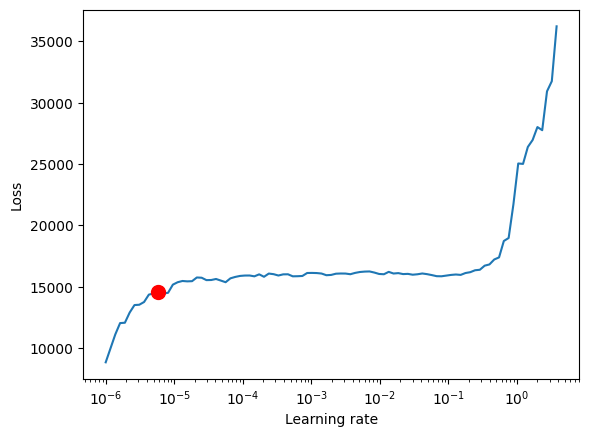

In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-FindOptimalLR",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [ ]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    lstm_layers=1,
    hidden_size=16,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 628    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Number of parameters in network: 14.4k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 12576.146
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 12576.146


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 57.699 >= min_delta = 0.0001. New best score: 12518.447
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 57.699 >= min_delta = 0.0001. New best score: 12518.447


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 23.532 >= min_delta = 0.0001. New best score: 12494.915
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 23.532 >= min_delta = 0.0001. New best score: 12494.915


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 4.397 >= min_delta = 0.0001. New best score: 12490.518
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 4.397 >= min_delta = 0.0001. New best score: 12490.518


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 40.340 >= min_delta = 0.0001. New best score: 12450.178
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 40.340 >= min_delta = 0.0001. New best score: 12450.178


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 11.854 >= min_delta = 0.0001. New best score: 12438.324
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 11.854 >= min_delta = 0.0001. New best score: 12438.324


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 12438.324. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 12438.324. Signaling Trainer to stop.


## Experiment 6

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 94 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 94 steps due to diverging loss.
INFO: Learning rate set to 5.888436553555889e-06
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 5.888436553555889e-06
INFO: Restoring states from the checkpoint path at /content/.lr_find_e896e5e6-af43-4a90-91c3-58440fc2b04f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_e896e5e6-af43-4a90-91c3-58440fc2b04f.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_e896e5e6-af43-4a90-91c3-58440fc2b04f.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_e896e5e6-af43-4a90-91c3-58440fc2b04f.ckpt


Best LR: 5.888436553555889e-06


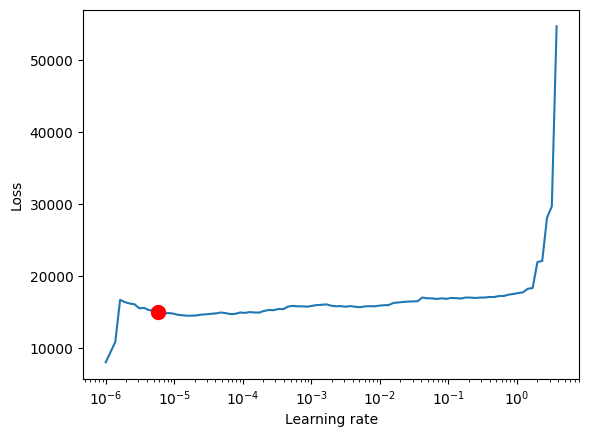

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | M

Number of parameters in network: 14.5k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 7576.441
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 7576.441


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 196.595 >= min_delta = 0.0001. New best score: 7379.847
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 196.595 >= min_delta = 0.0001. New best score: 7379.847


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 68.769 >= min_delta = 0.0001. New best score: 7311.078
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 68.769 >= min_delta = 0.0001. New best score: 7311.078


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 39.055 >= min_delta = 0.0001. New best score: 7272.023
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 39.055 >= min_delta = 0.0001. New best score: 7272.023


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 23.012 >= min_delta = 0.0001. New best score: 7249.011
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 23.012 >= min_delta = 0.0001. New best score: 7249.011


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 18.511 >= min_delta = 0.0001. New best score: 7230.500
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 18.511 >= min_delta = 0.0001. New best score: 7230.500


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 20.014 >= min_delta = 0.0001. New best score: 7210.486
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 20.014 >= min_delta = 0.0001. New best score: 7210.486


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 4.853 >= min_delta = 0.0001. New best score: 7205.634
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 4.853 >= min_delta = 0.0001. New best score: 7205.634


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 12.957 >= min_delta = 0.0001. New best score: 7192.677
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 12.957 >= min_delta = 0.0001. New best score: 7192.677


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 13.496 >= min_delta = 0.0001. New best score: 7179.182
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 13.496 >= min_delta = 0.0001. New best score: 7179.182
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-QuantileLoss",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"Best LR: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    lstm_layers=1,
    hidden_size=16,
    dropout=0,
    output_size=7,
    loss=QuantileLoss(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 92 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 92 steps due to diverging loss.
INFO: Learning rate set to 0.00017378008287493755
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.00017378008287493755
INFO: Restoring states from the checkpoint path at /content/.lr_find_1af673c9-a20e-4c38-8934-dd7573e778b8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_1af673c9-a20e-4c38-8934-dd7573e778b8.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_1af673c9-a20e-4c38-8934-dd7573e778b8.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_1af673c9-a20e-4c38-8934-dd7573e778b8.ckpt


Best LR: 0.00017378008287493755


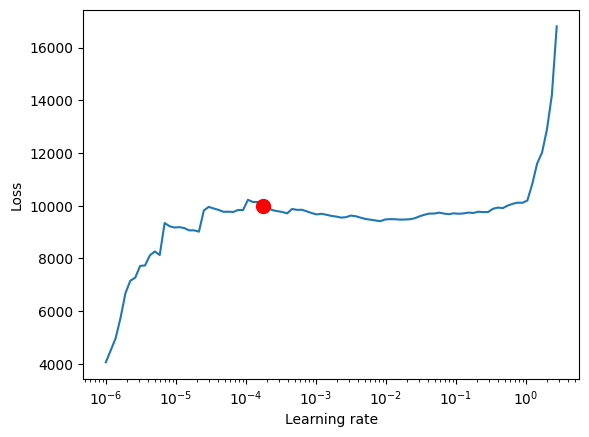

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Number of parameters in network: 209.3k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 7082.111
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 7082.111


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 16.432 >= min_delta = 0.0001. New best score: 7065.679
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 16.432 >= min_delta = 0.0001. New best score: 7065.679


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 7065.679. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 7065.679. Signaling Trainer to stop.


In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-QuantileLoss-Hidden-64",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"Best LR: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    lstm_layers=1,
    hidden_size=64,
    dropout=0,
    output_size=7,
    loss=QuantileLoss(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 88 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 88 steps due to diverging loss.
INFO: Learning rate set to 5.888436553555889e-06
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 5.888436553555889e-06
INFO: Restoring states from the checkpoint path at /content/.lr_find_71b3e3f7-00fe-4f76-846f-fbdcfbab6fcb.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_71b3e3f7-00fe-4f76-846f-fbdcfbab6fcb.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_71b3e3f7-00fe-4f76-846f-fbdcfbab6fcb.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_71b3e3f7-00fe-4f76-846f-fbdcfbab6fcb.ckpt


Best LR: 5.888436553555889e-06


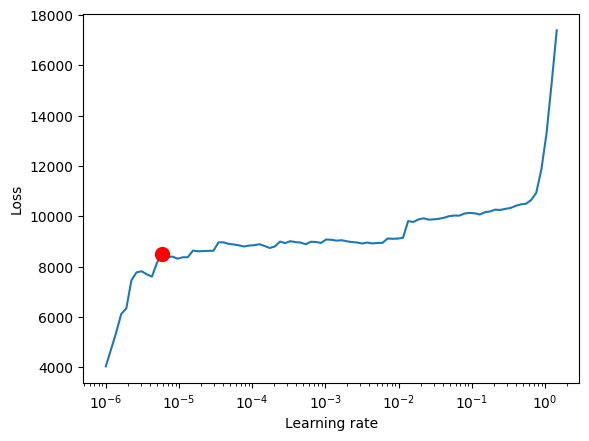

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Number of parameters in network: 275.9k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 7118.630
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 7118.630


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 27.745 >= min_delta = 0.0001. New best score: 7090.886
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 27.745 >= min_delta = 0.0001. New best score: 7090.886


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.534 >= min_delta = 0.0001. New best score: 7089.352
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.534 >= min_delta = 0.0001. New best score: 7089.352


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 3.293 >= min_delta = 0.0001. New best score: 7086.059
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 3.293 >= min_delta = 0.0001. New best score: 7086.059


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 7086.059. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 7086.059. Signaling Trainer to stop.


In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-QuantileLoss-Hidden-64-LSTM-2",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"Best LR: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    lstm_layers=2,
    hidden_size=64,
    dropout=0,
    output_size=7,
    loss=QuantileLoss(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 87 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 87 steps due to diverging loss.
INFO: Learning rate set to 2.951209226666385e-05
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 2.951209226666385e-05
INFO: Restoring states from the checkpoint path at /content/.lr_find_935205d3-8ee9-48be-8c61-6662d857a27c.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_935205d3-8ee9-48be-8c61-6662d857a27c.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_935205d3-8ee9-48be-8c61-6662d857a27c.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_935205d3-8ee9-48be-8c61-6662d857a27c.ckpt


Best LR: 2.951209226666385e-05


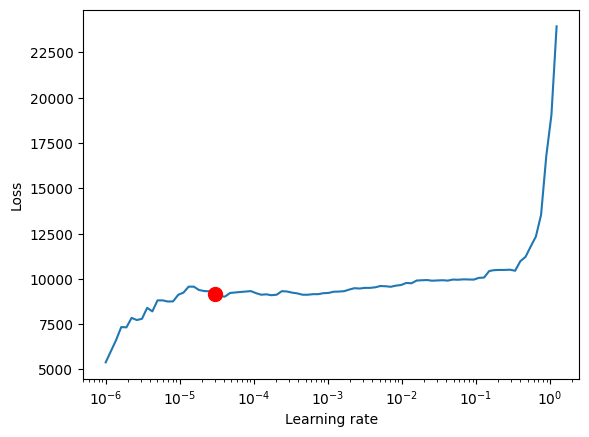

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Number of parameters in network: 275.5k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 12432.749
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 12432.749


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 12432.749. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 12432.749. Signaling Trainer to stop.


In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-MAE-Hidden-64-LSTM-2",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"Best LR: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    lstm_layers=2,
    hidden_size=64,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 84 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 84 steps due to diverging loss.
INFO: Learning rate set to 2.951209226666385e-05
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 2.951209226666385e-05
INFO: Restoring states from the checkpoint path at /content/.lr_find_a93f4103-4003-4c01-b9dc-3beb8626ff9e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_a93f4103-4003-4c01-b9dc-3beb8626ff9e.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_a93f4103-4003-4c01-b9dc-3beb8626ff9e.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_a93f4103-4003-4c01-b9dc-3beb8626ff9e.ckpt


Best LR: 2.951209226666385e-05


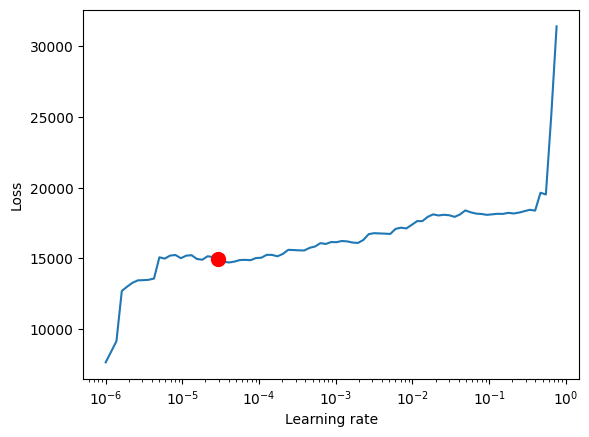

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | M

Number of parameters in network: 275.5k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 12574.238
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 12574.238


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 49.307 >= min_delta = 0.0001. New best score: 12524.932
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 49.307 >= min_delta = 0.0001. New best score: 12524.932


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 12524.932. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 12524.932. Signaling Trainer to stop.


In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-MAE-Dropout-0.5",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"Best LR: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    lstm_layers=2,
    hidden_size=64,
    dropout=0.5,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

In [ ]:
train_processed = pipeline.transform(train)
test_processed = pipeline.transform(test)

training = TimeSeriesDataSet(
    data=train_processed,
    time_idx="Week",
    group_ids=["Store", "Dept"],
    target="Weekly_Sales",
    weight="Weight",
    allow_missing_timesteps=True,
    max_encoder_length=30, # Max history for time series
    static_categoricals=['Type'],
    static_reals=['Size'],
    min_prediction_length=1,
    max_prediction_length=1,
)
validation = TimeSeriesDataSet.from_dataset(training, test_processed, stop_randomization=True, predict=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 200 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Store': 1, '__group_id__Dept': 78}, {'__group_id__Store': 1, '__group_id__Dept': 99}, {'__group_id__Store': 2, '__group_id__Dept': 39}, {'__group_id__Store': 2, '__group_id__Dept': 51}, {'__group_id__Store': 2, '__group_id__Dept': 78}, {'__group_id__Store': 2, '__group_id__Dept': 99}, {'__group_id__Store': 3, '__group_id__Dept': 45}, {'__group_id__Store': 3, '__group_id__Dept': 47}, {'__group_id__Store': 3, '__group_id__Dept': 49}, {'__group_id__Store': 3, '__group_id__Dept': 77}]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min e

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 19 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 19 steps due to diverging loss.
INFO: Learning rate set to 1.3182567385564071e-05
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 1.3182567385564071e-05
INFO: Restoring states from the checkpoint path at /content/.lr_find_a5a55d93-4fc5-4622-b1f9-146fa383b776.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_a5a55d93-4fc5-4622-b1f9-146fa383b776.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_a5a55d93-4fc5-4622-b1f9-146fa383b776.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_a5a55d93-4fc5-4622-b1f9-146fa383b776.ckpt


Best LR: 1.3182567385564071e-05


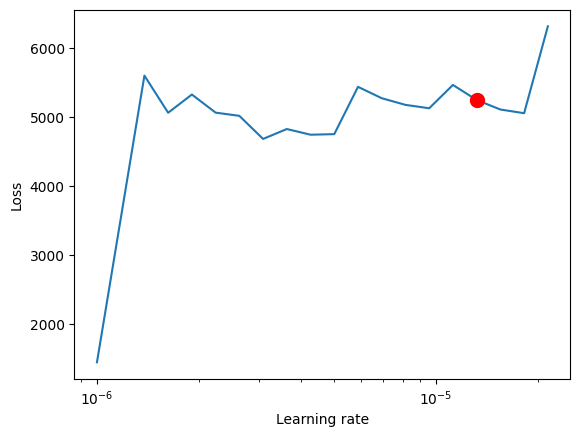

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Number of parameters in network: 275.5k


INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 2104.531
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2104.531


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 37.135 >= min_delta = 0.0001. New best score: 2067.396
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 37.135 >= min_delta = 0.0001. New best score: 2067.396


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 2067.396. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 2067.396. Signaling Trainer to stop.


In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-MAE-History-30",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"Best LR: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    lstm_layers=2,
    hidden_size=64,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 87 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 87 steps due to diverging loss.
INFO: Learning rate set to 0.0051286138399136505
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.0051286138399136505
INFO: Restoring states from the checkpoint path at /content/.lr_find_5f0df797-16d3-498c-9475-f57ac9e1b2c1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_5f0df797-16d3-498c-9475-f57ac9e1b2c1.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_5f0df797-16d3-498c-9475-f57ac9e1b2c1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_5f0df797-16d3-498c-9475-f57ac9e1b2c1.ckpt


Best LR: 0.0051286138399136505


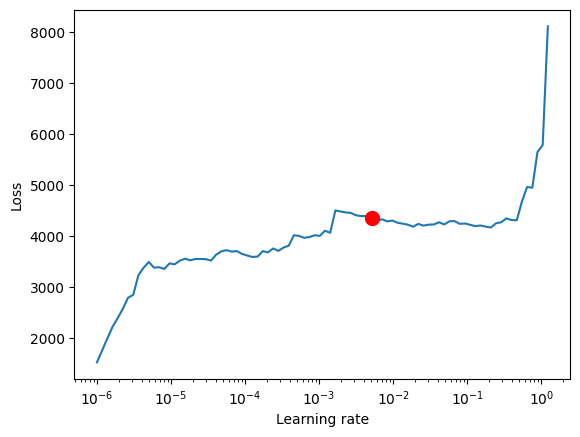

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | M

Number of parameters in network: 275.9k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 1191.328
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 1191.328


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 1191.328. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 1191.328. Signaling Trainer to stop.


In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-QuantileLoss-History-30",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"Best LR: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    lstm_layers=2,
    hidden_size=64,
    dropout=0,
    output_size=7,
    loss=QuantileLoss(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

In [ ]:
val_pred = tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


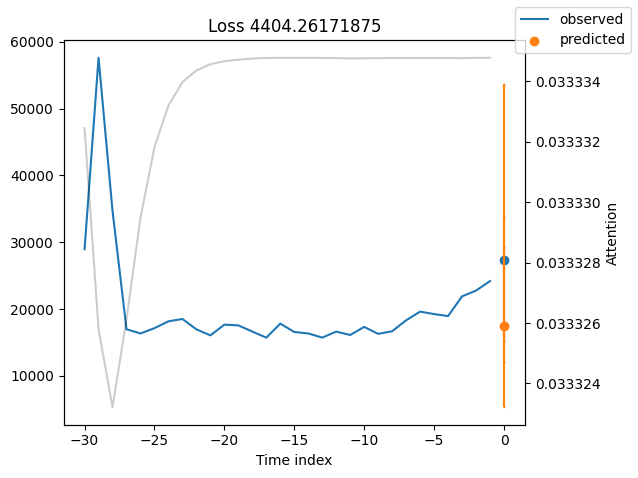

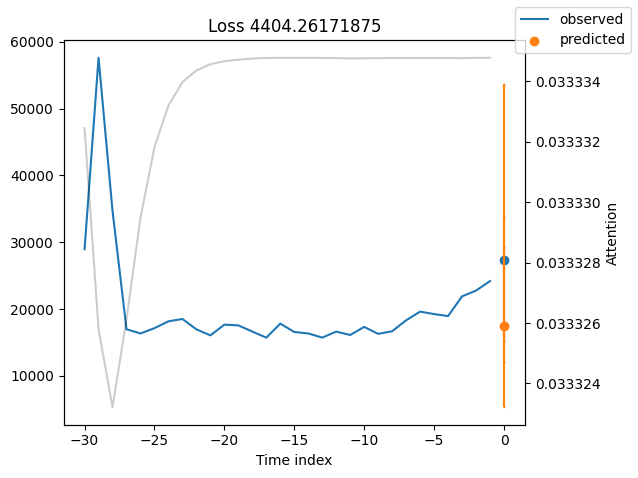

In [ ]:
tft.plot_prediction(x=val_pred.x, out=val_pred.output, idx=0, add_loss_to_title=True)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during che

Number of parameters in network: 275.5k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 89 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 89 steps due to diverging loss.
INFO: Learning rate set to 7.585775750291837e-07
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 7.585775750291837e-07
INFO: Restoring states from the checkpoint path at /content/.lr_find_910d3086-9435-47db-94df-2b3bc551fd98.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_910d3086-9435-47db-94df-2b3bc551fd98.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_910d3086-9435-47db-94df-2b3bc551fd98.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_910d3086-9435-47db-94df-2b3bc551fd98.ckpt


Number of parameters in network: 275.5k
Best LR: 7.585775750291837e-07


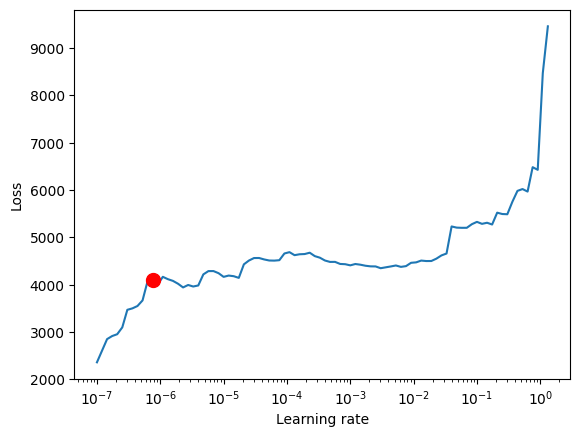

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 2084.835
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2084.835


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 2084.835. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 2084.835. Signaling Trainer to stop.


In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-MAE-History-30-Dropout-0.5",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1,
    lstm_layers=2,
    hidden_size=64,
    dropout=0.5,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-7,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    lstm_layers=2,
    hidden_size=64,
    dropout=0.5,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

print(f"Best LR: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()


trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-MAE-History-30-Dropout-0.5-FixedLR",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-6,
    lstm_layers=2,
    hidden_size=64,
    dropout=0.5,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during che

Number of parameters in network: 275.5k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 2115.362
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2115.362


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 54.158 >= min_delta = 0.0001. New best score: 2061.204
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 54.158 >= min_delta = 0.0001. New best score: 2061.204


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 4.798 >= min_delta = 0.0001. New best score: 2056.406
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 4.798 >= min_delta = 0.0001. New best score: 2056.406


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 3.867 >= min_delta = 0.0001. New best score: 2052.539
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 3.867 >= min_delta = 0.0001. New best score: 2052.539


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 3.507 >= min_delta = 0.0001. New best score: 2049.032
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 3.507 >= min_delta = 0.0001. New best score: 2049.032
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-MAE-Hidden-128",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-6,
    lstm_layers=2,
    hidden_size=128,
    dropout=0.5,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 1087.4k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 3.5 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
from pytorch_forecasting.data import TorchNormalizer

train_processed = pipeline.transform(train)
test_processed = pipeline.transform(test)

training = TimeSeriesDataSet(
    data=train_processed,
    time_idx="Week",
    group_ids=["Store", "Dept"],
    target="Weekly_Sales",
    weight="Weight",
    allow_missing_timesteps=True,
    max_encoder_length=30, # Max history for time series
    static_categoricals=['Type'],
    static_reals=['Size'],
    min_prediction_length=1,
    max_prediction_length=1,
    target_normalizer=TorchNormalizer(),
)
validation = TimeSeriesDataSet.from_dataset(training, test_processed, stop_randomization=True, predict=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 200 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Store': 1, '__group_id__Dept': 78}, {'__group_id__Store': 1, '__group_id__Dept': 99}, {'__group_id__Store': 2, '__group_id__Dept': 39}, {'__group_id__Store': 2, '__group_id__Dept': 51}, {'__group_id__Store': 2, '__group_id__Dept': 78}, {'__group_id__Store': 2, '__group_id__Dept': 99}, {'__group_id__Store': 3, '__group_id__Dept': 45}, {'__group_id__Store': 3, '__group_id__Dept': 47}, {'__group_id__Store': 3, '__group_id__Dept': 49}, {'__group_id__Store': 3, '__group_id__Dept': 77}]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min e

In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-1-MAE-Hidden-64-TorchNormalizer",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-6,
    lstm_layers=2,
    hidden_size=64,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during che

Number of parameters in network: 275.5k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
from pytorch_forecasting.data import TorchNormalizer

train_processed = pipeline.transform(train)
test_processed = pipeline.transform(test)

training = TimeSeriesDataSet(
    data=train_processed,
    time_idx="Week",
    group_ids=["Store", "Dept"],
    target="Weekly_Sales",
    weight="Weight",
    allow_missing_timesteps=True,
    max_encoder_length=30, # Max history for time series
    static_categoricals=['Type'],
    static_reals=['Size'],
    min_prediction_length=5,
    max_prediction_length=5,
)
validation = TimeSeriesDataSet.from_dataset(training, test_processed, stop_randomization=True, predict=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 207 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Store': 1, '__group_id__Dept': 78}, {'__group_id__Store': 1, '__group_id__Dept': 99}, {'__group_id__Store': 2, '__group_id__Dept': 39}, {'__group_id__Store': 2, '__group_id__Dept': 51}, {'__group_id__Store': 2, '__group_id__Dept': 78}, {'__group_id__Store': 3, '__group_id__Dept': 45}, {'__group_id__Store': 3, '__group_id__Dept': 47}, {'__group_id__Store': 3, '__group_id__Dept': 49}, {'__group_id__Store': 3, '__group_id__Dept': 77}, {'__group_id__Store': 3, '__group_id__Dept': 78}]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min e

In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-5-MAE-Hidden-64",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-6,
    lstm_layers=2,
    hidden_size=64,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during che

Number of parameters in network: 275.5k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 1969.947
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 1969.947


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 1 records. Best score: 1969.947. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 1969.947. Signaling Trainer to stop.


In [ ]:
val_pred = tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


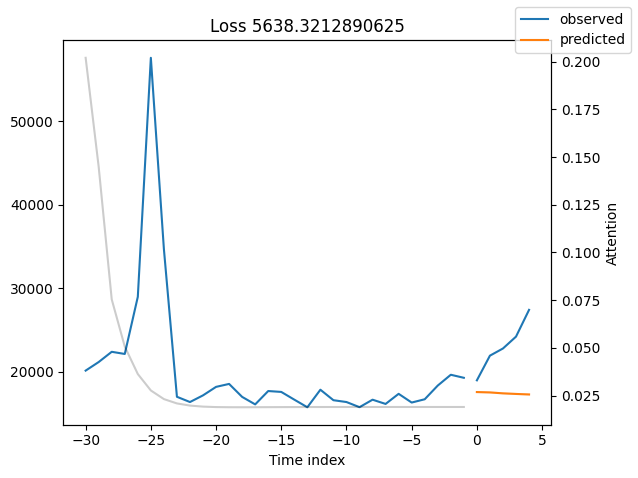

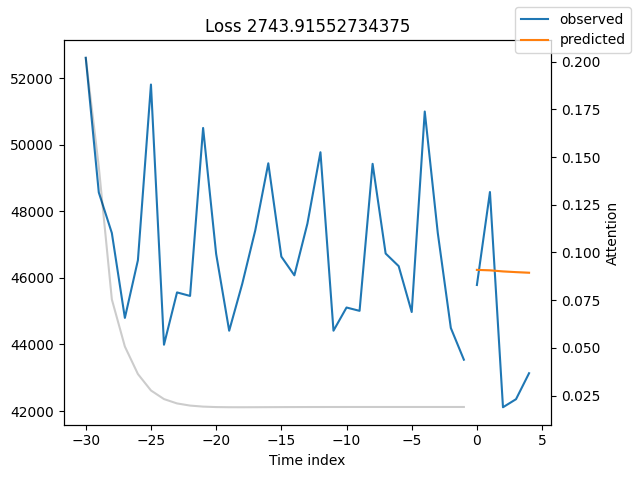

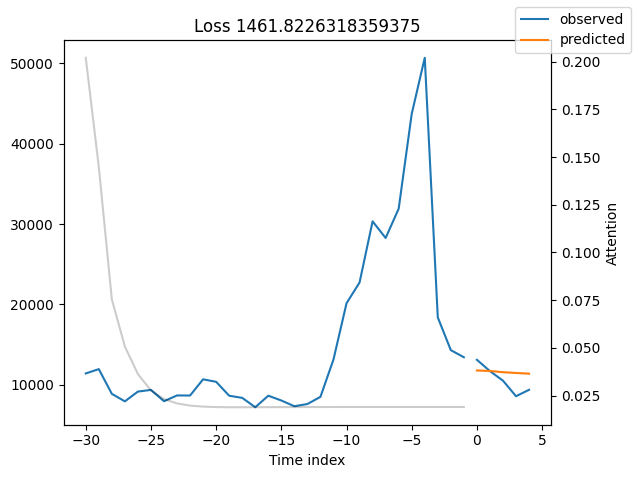

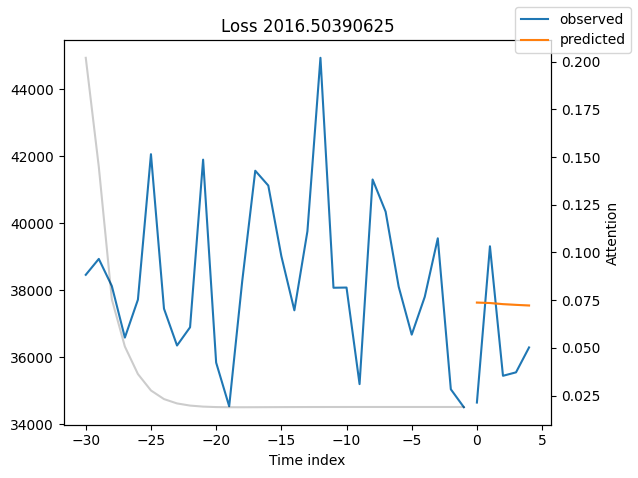

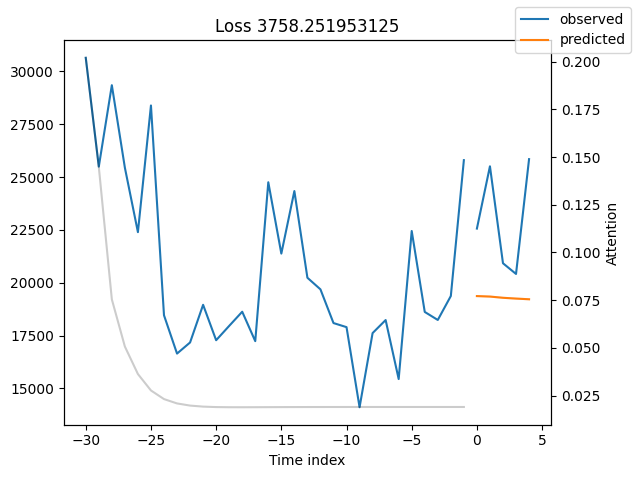

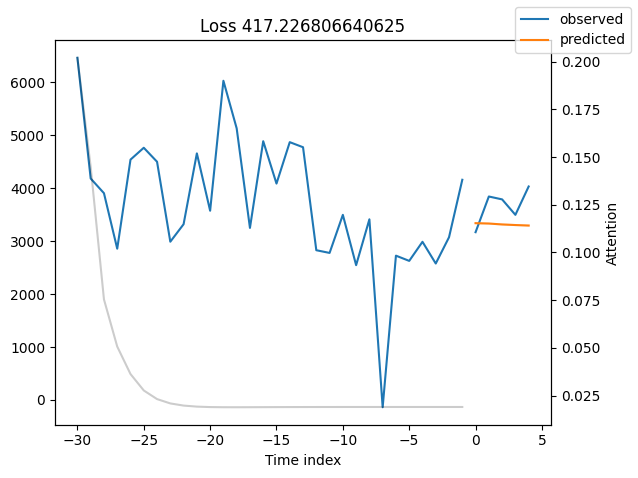

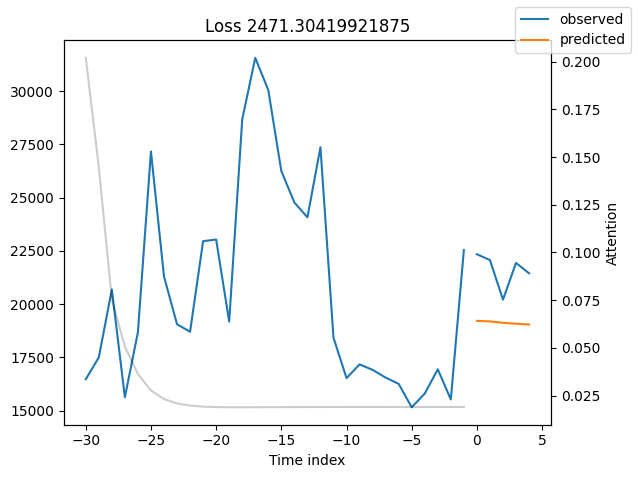

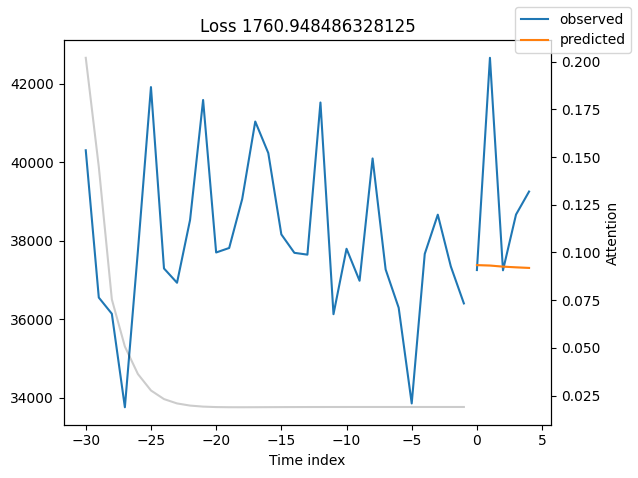

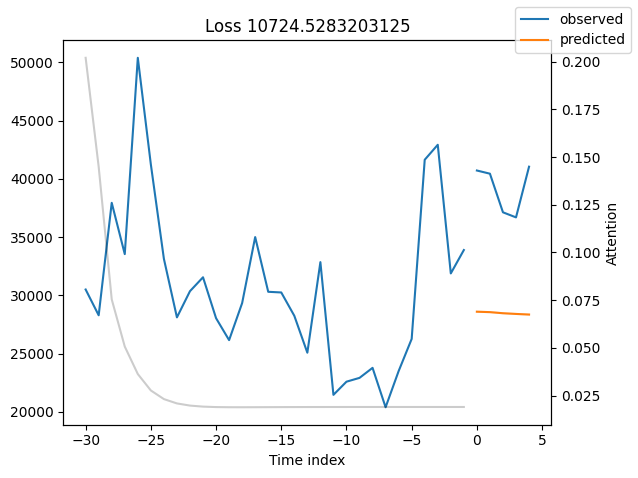

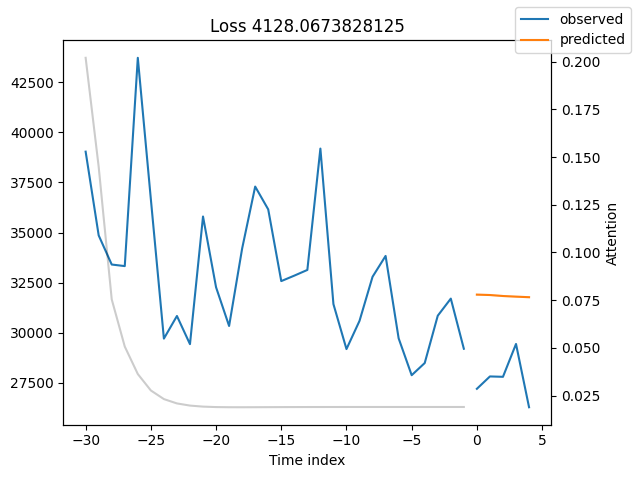

In [ ]:
for i in range(10):
  tft.plot_prediction(x=val_pred.x, out=val_pred.output, idx=i, add_loss_to_title=True)

In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-5-MAE-Hidden-64-Epoch-20",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=20,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-6,
    lstm_layers=2,
    hidden_size=64,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during che

Number of parameters in network: 275.5k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


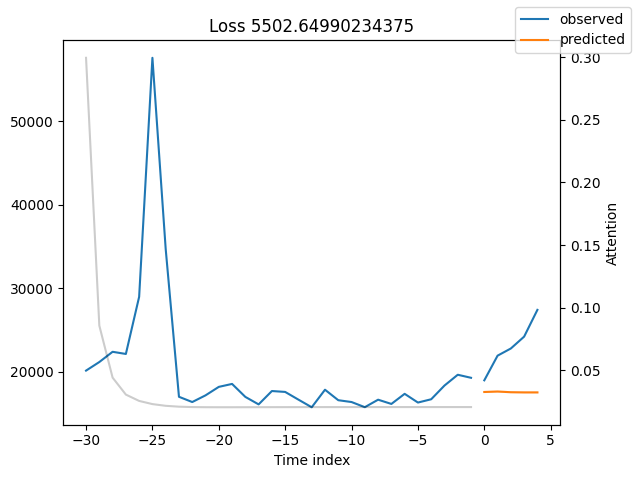

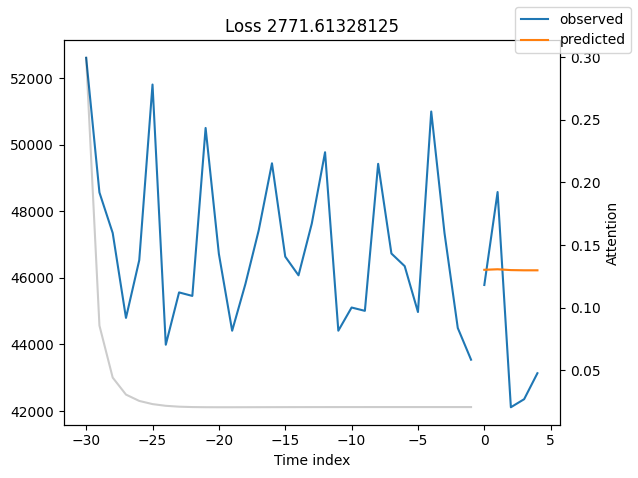

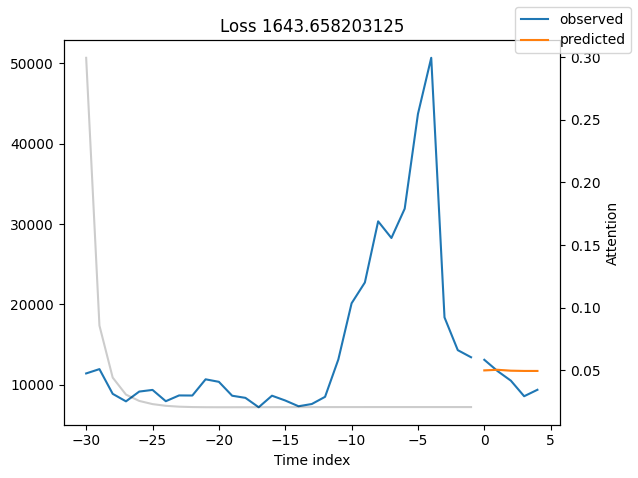

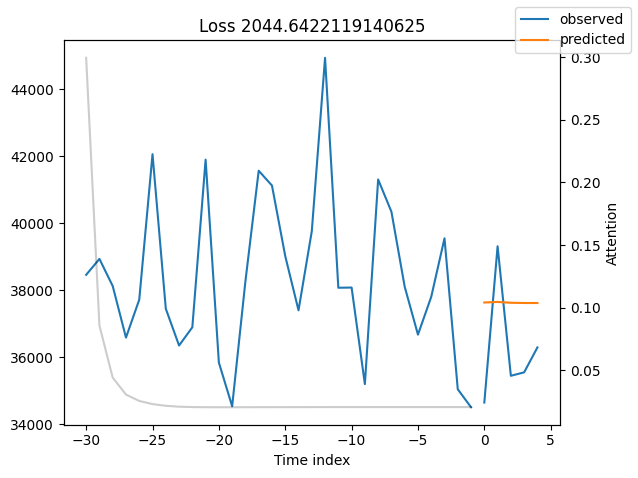

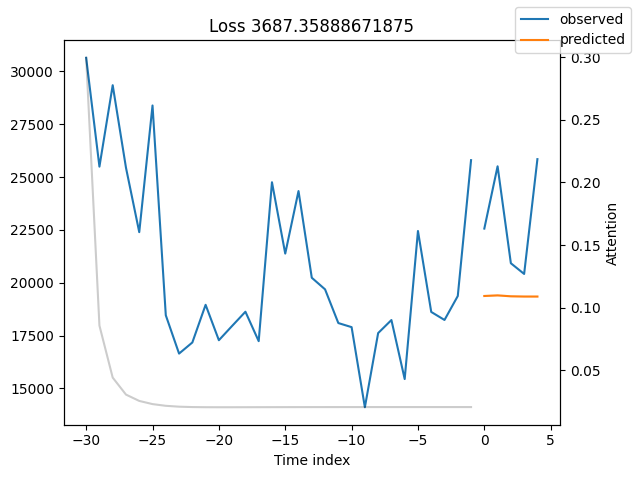

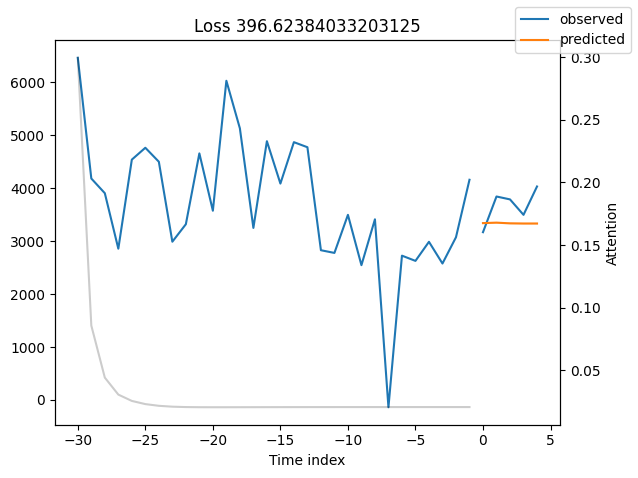

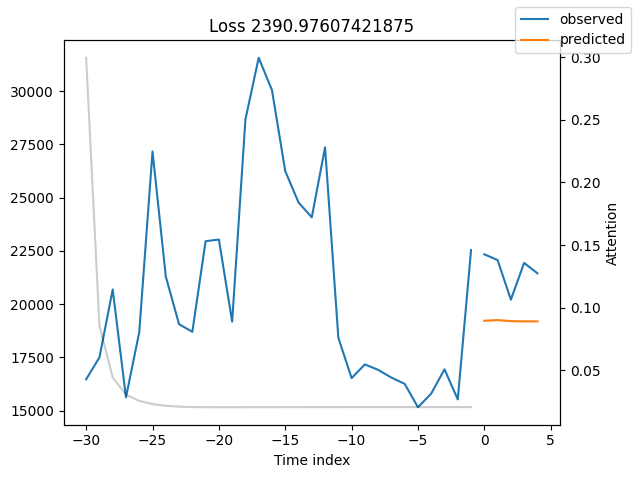

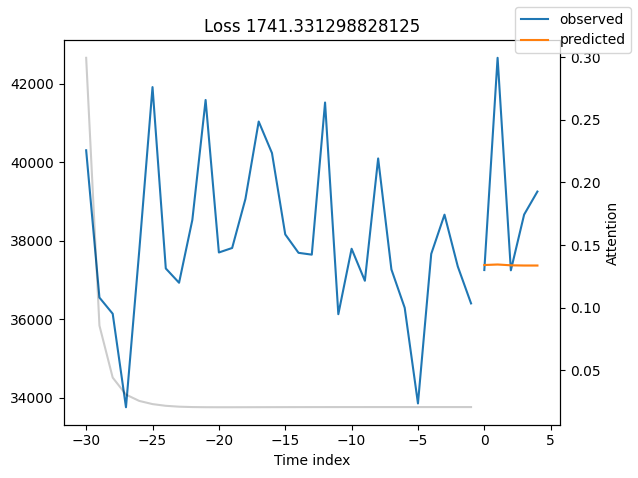

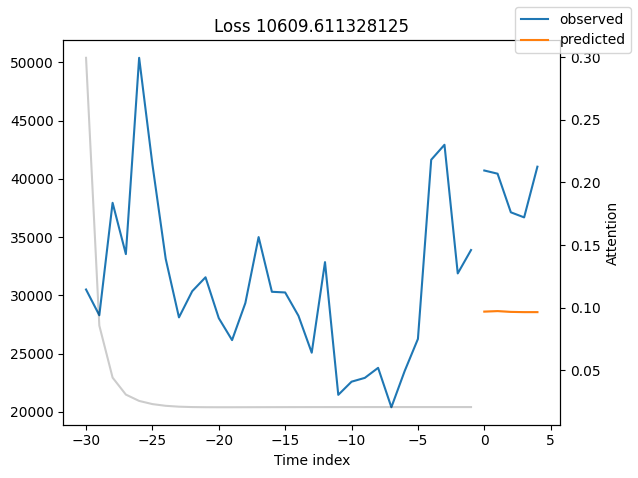

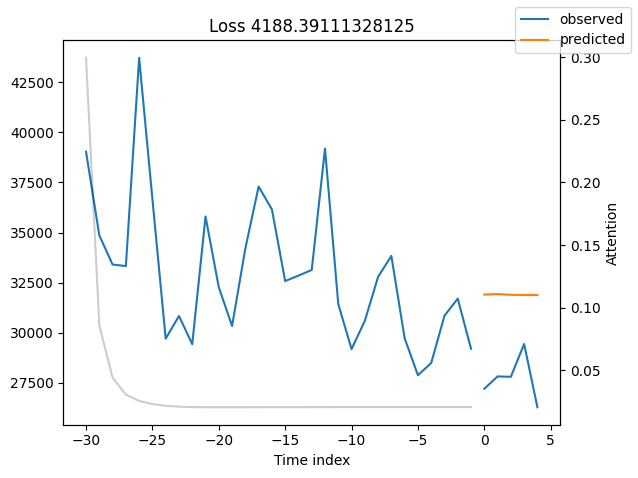

In [ ]:
val_pred = tft.predict(val_dataloader, mode="raw", return_x=True)
for i in range(10):
  tft.plot_prediction(x=val_pred.x, out=val_pred.output, idx=i, add_loss_to_title=True)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-

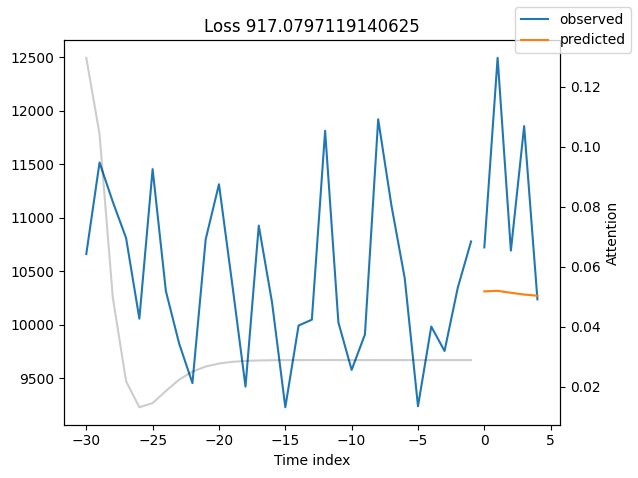

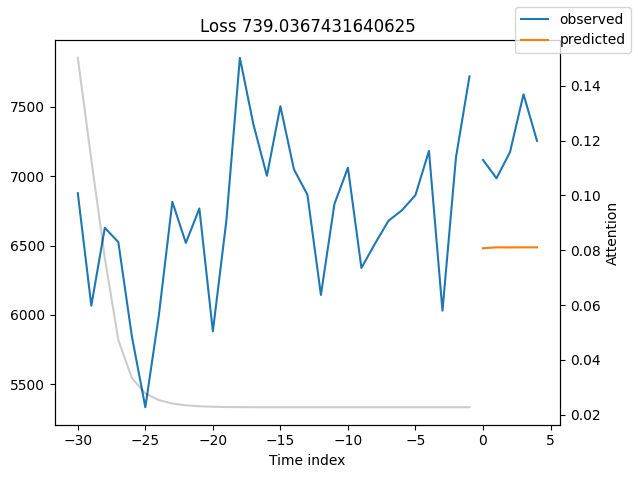

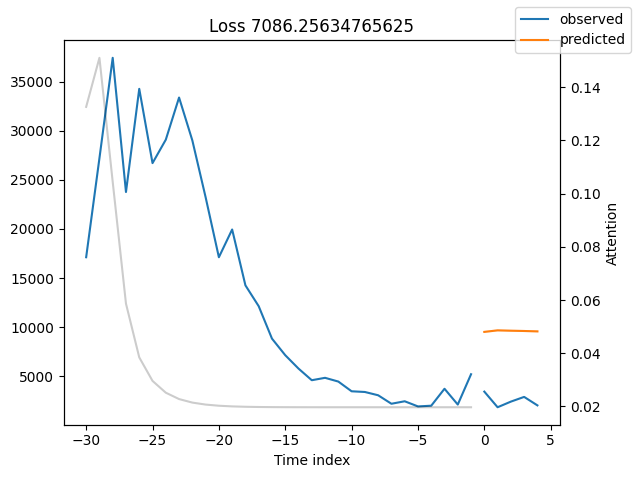

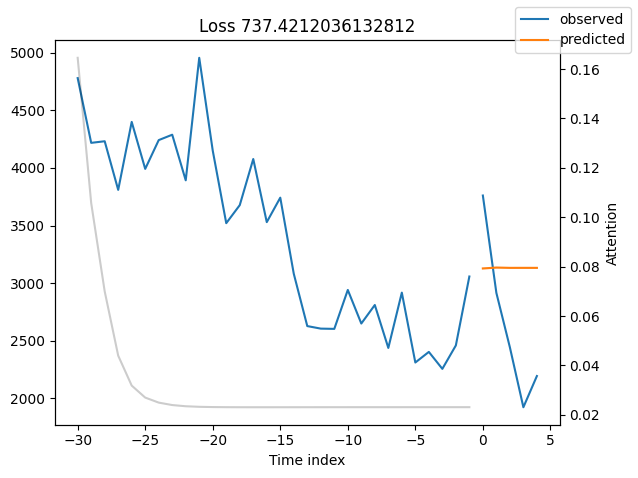

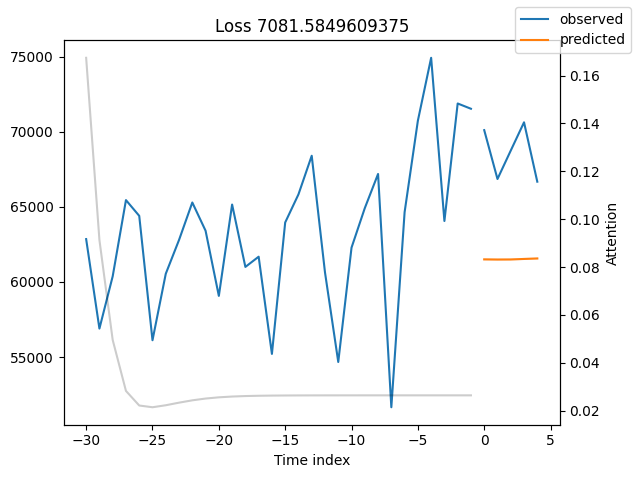

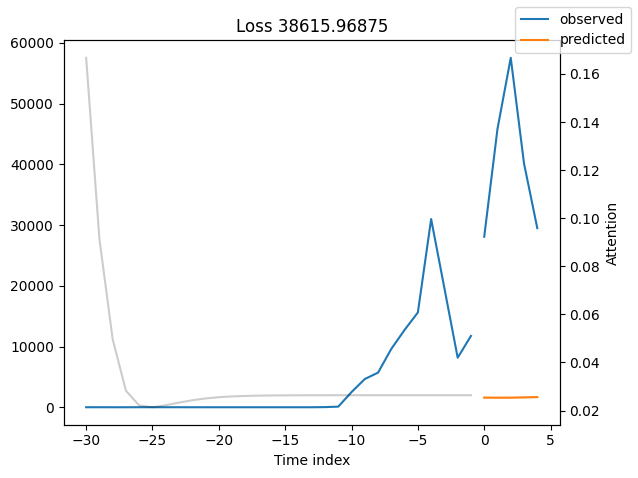

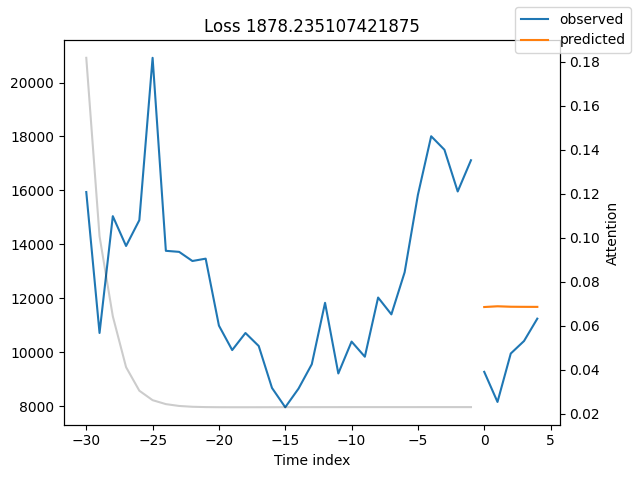

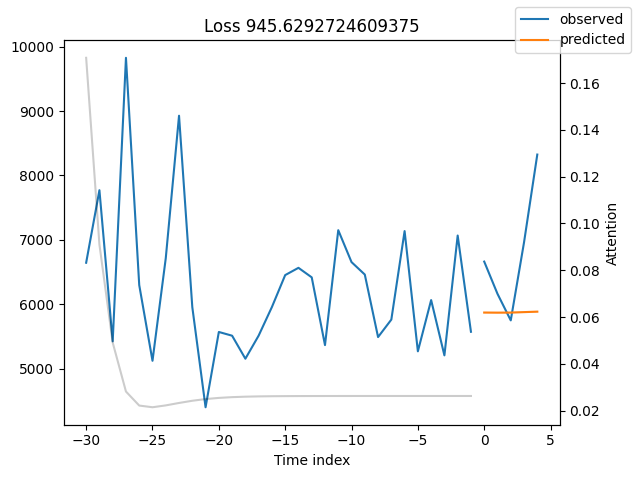

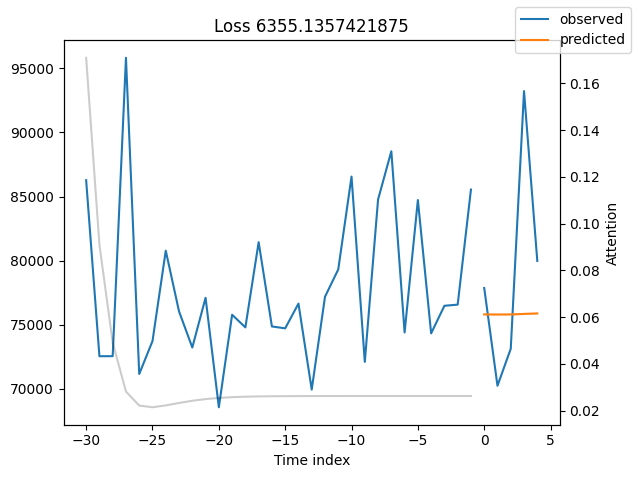

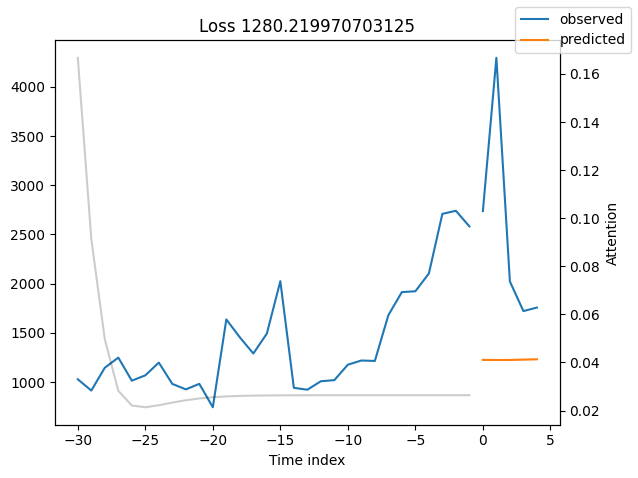

In [ ]:
train_pred = tft.predict(train_dataloader, mode="raw", return_x=True)
for i in range(10):
  tft.plot_prediction(x=train_pred.x, out=train_pred.output, idx=i, add_loss_to_title=True)

In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-5-MAE-Hidden-64-HigherLR",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-2,
    lstm_layers=2,
    hidden_size=64,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

#wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during che

Number of parameters in network: 275.5k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


<Artifact pipeline>

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


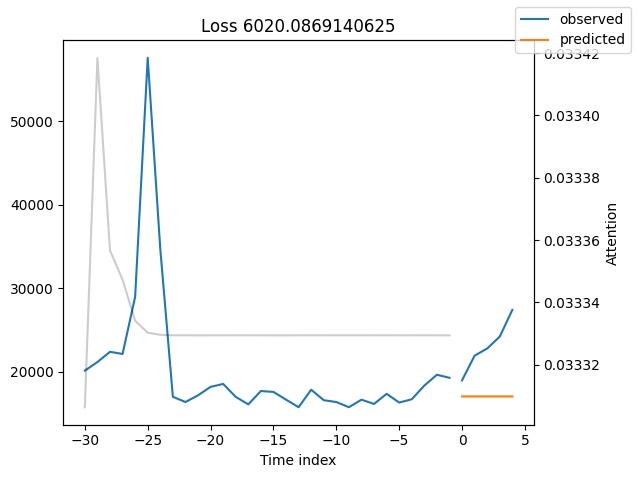

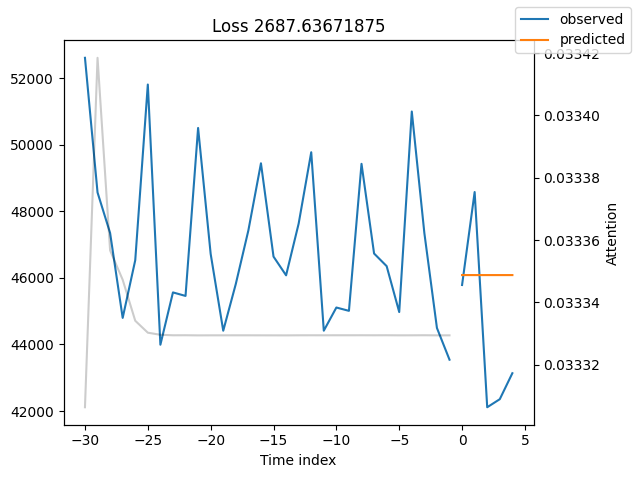

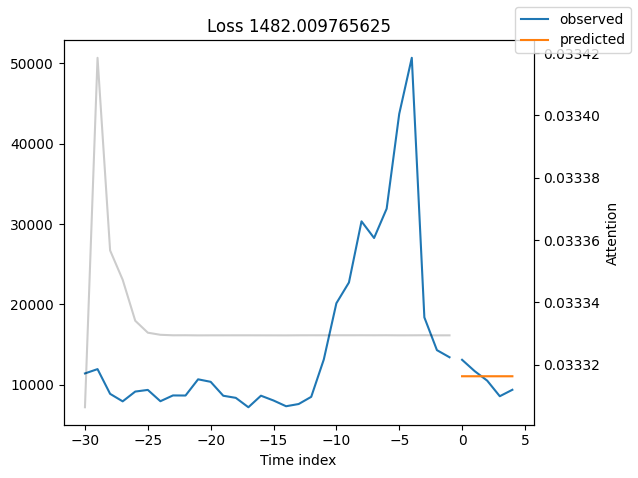

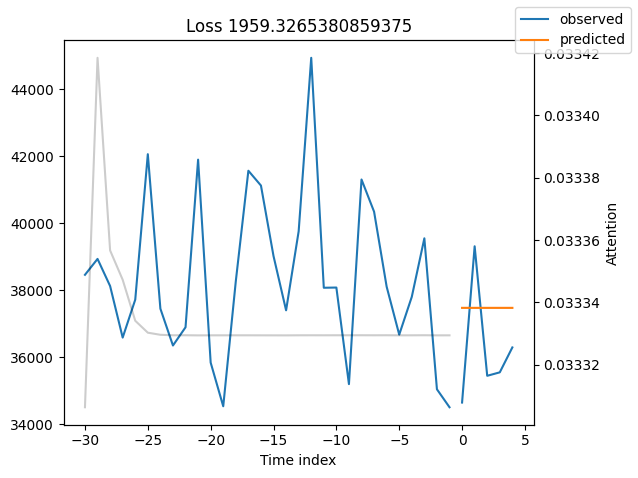

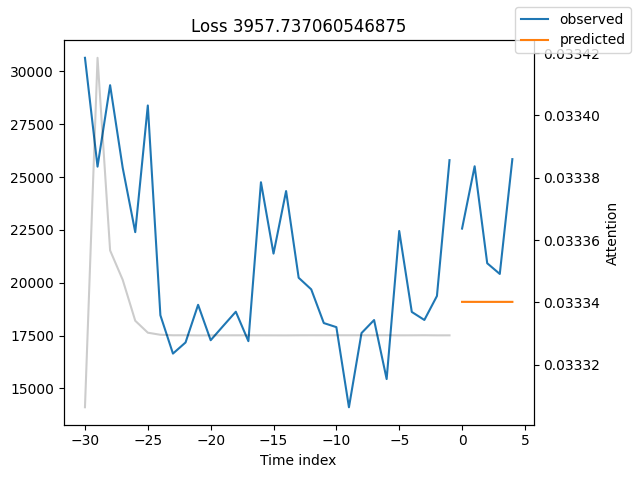

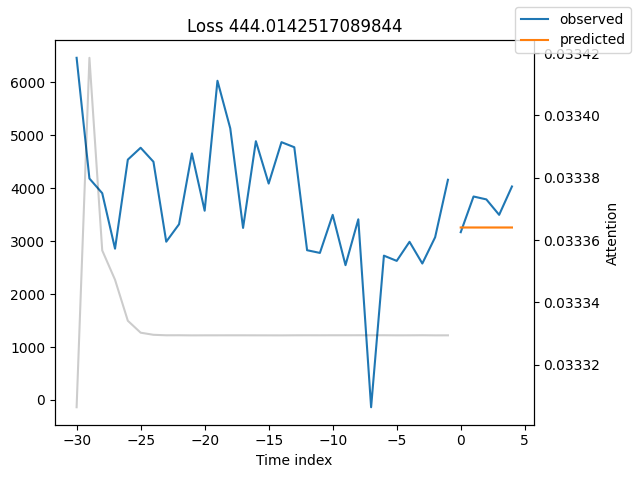

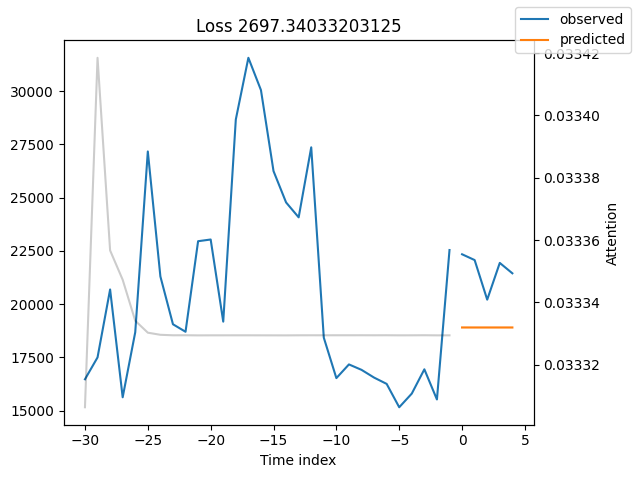

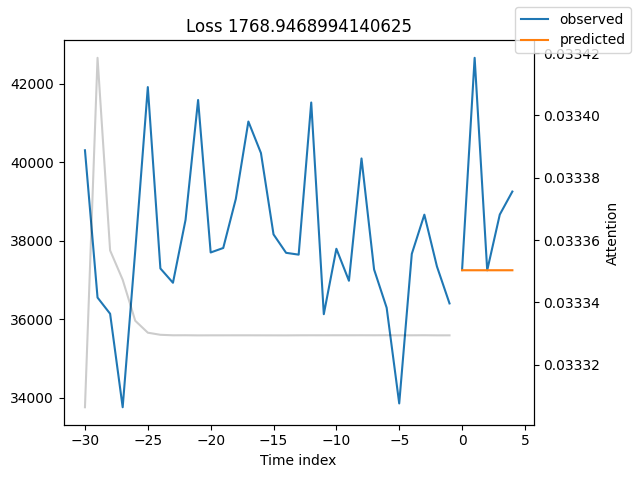

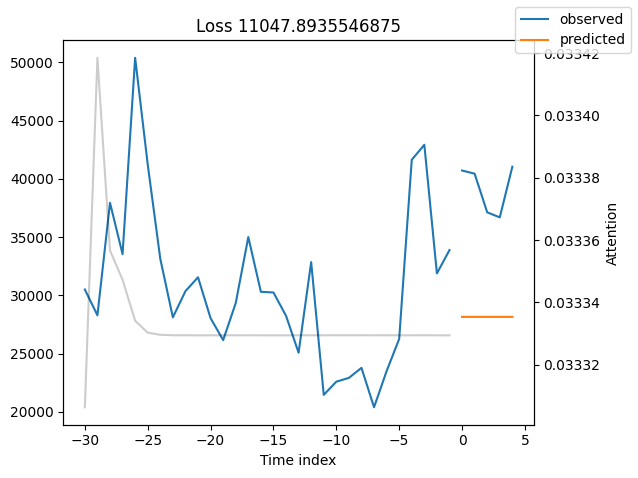

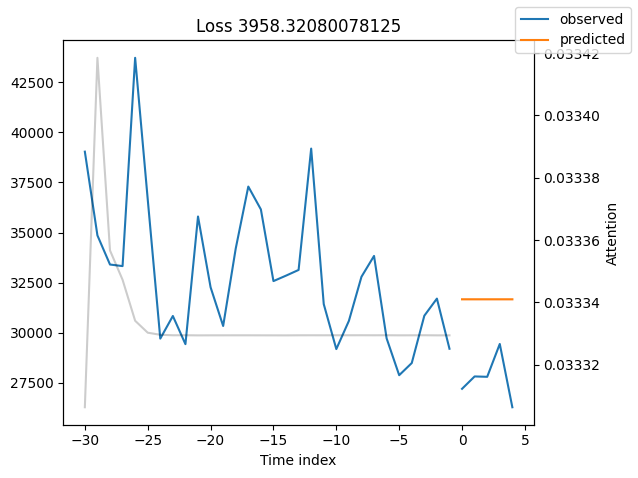

In [ ]:
val_pred = tft.predict(val_dataloader, mode="raw", return_x=True)
for i in range(10):
  tft.plot_prediction(x=val_pred.x, out=val_pred.output, idx=i, add_loss_to_title=True)

In [ ]:
trainer.validate(tft, val_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_MAE          │     1966.53955078125      │
│         val_MAPE          │      32128.095703125      │
│         val_RMSE          │       3993.1953125        │
│         val_SMAPE         │    0.2641717791557312     │
│         val_loss          │     1966.53955078125      │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1966.53955078125,
  'val_SMAPE': 0.2641717791557312,
  'val_MAE': 1966.53955078125,
  'val_RMSE': 3993.1953125,
  'val_MAPE': 32128.095703125}]

In [ ]:
wandb.finish()

In [ ]:
from pytorch_forecasting.data import TorchNormalizer, GroupNormalizer

train_processed = pipeline.transform(train)
test_processed = pipeline.transform(test)

training = TimeSeriesDataSet(
    data=train_processed,
    time_idx="Week",
    group_ids=["Store", "Dept"],
    target="Weekly_Sales",
    weight="Weight",
    allow_missing_timesteps=True,
    max_encoder_length=30, # Max history for time series
    static_categoricals=['Type'],
    static_reals=['Size'],
    min_prediction_length=5,
    max_prediction_length=5,
    target_normalizer=GroupNormalizer(
        groups=["Store", "Dept"], transformation="softplus"
    ),
)
validation = TimeSeriesDataSet.from_dataset(training, test_processed, stop_randomization=True, predict=True)

batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 207 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Store': 1, '__group_id__Dept': 78}, {'__group_id__Store': 1, '__group_id__Dept': 99}, {'__group_id__Store': 2, '__group_id__Dept': 39}, {'__group_id__Store': 2, '__group_id__Dept': 51}, {'__group_id__Store': 2, '__group_id__Dept': 78}, {'__group_id__Store': 3, '__group_id__Dept': 45}, {'__group_id__Store': 3, '__group_id__Dept': 47}, {'__group_id__Store': 3, '__group_id__Dept': 49}, {'__group_id__Store': 3, '__group_id__Dept': 77}, {'__group_id__Store': 3, '__group_id__Dept': 78}]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/data/timeseries/_timeseries.py:1847: UserWarning: Min e

In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-5-MAE-Hidden-64-GroupNormalizer",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-5,
    lstm_layers=2,
    hidden_size=64,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during che

Number of parameters in network: 275.5k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/metrics/base_metrics.py:905: UserWarning: Loss is not finite. Resetting it to 1e9
  warnings.warn("Loss is not finite. Resetting it to 1e9")


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 269942.938
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 269942.938


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.500 >= min_delta = 0.0001. New best score: 269941.438
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.500 >= min_delta = 0.0001. New best score: 269941.438


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.312 >= min_delta = 0.0001. New best score: 269941.125
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.312 >= min_delta = 0.0001. New best score: 269941.125


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.000 >= min_delta = 0.0001. New best score: 269940.125
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.000 >= min_delta = 0.0001. New best score: 269940.125


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.719 >= min_delta = 0.0001. New best score: 269938.406
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.719 >= min_delta = 0.0001. New best score: 269938.406
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-5-MAE-Hidden-16-GroupNormalizer",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-5,
    lstm_layers=1,
    hidden_size=16,
    dropout=0,
    output_size=1,
    loss=MAE(),
    attention_head_size=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 14.4k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 628    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 269952.125
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 269952.125


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 4.281 >= min_delta = 0.0001. New best score: 269947.844
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 4.281 >= min_delta = 0.0001. New best score: 269947.844


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 2.375 >= min_delta = 0.0001. New best score: 269945.469
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.375 >= min_delta = 0.0001. New best score: 269945.469


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 2.438 >= min_delta = 0.0001. New best score: 269943.031
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.438 >= min_delta = 0.0001. New best score: 269943.031


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 1.188 >= min_delta = 0.0001. New best score: 269941.844
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 1.188 >= min_delta = 0.0001. New best score: 269941.844
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
from lightning.pytorch.tuner import Tuner

wandb_logger = WandbLogger(
  project="walmart-recruiting-sales-TFT",
  name="TFT-SimpleFeats-Forecast-5-MAE-Hidden-16-GroupNormalizer-Dropout-0.5",
  log_model=True,
  entity="dachis-none"
)

lr_logger = LearningRateMonitor()

# Got the idea from official tutorial https://pytorch-forecasting.readthedocs.io/en/stable/getting-started.html
# We want to minimize validation loss and if it does not imporve for 1 epoch at least by 0.0001 then stop training
early_stopper = EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=1, verbose=True, mode="min")

trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",
    gradient_clip_val=0.1,
    log_every_n_steps=10,
    logger=wandb_logger,
    callbacks=[lr_logger, early_stopper],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-5,
    lstm_layers=1,
    hidden_size=16,
    dropout=0.5,
    output_size=1,
    loss=MAE(),
    attention_head_size=1,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

artifact = wandb.Artifact("pipeline", type="preprocessor")
artifact.add_file("pipeline.pkl")
wandb.log_artifact(artifact)

wandb.finish()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during che

Number of parameters in network: 14.8k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 9      | train
3  | prescalers                         | ModuleDict                      | 16     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 628    | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 0      | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 0      | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_forecasting/metrics/base_metrics.py:905: UserWarning: Loss is not finite. Resetting it to 1e9
  warnings.warn("Loss is not finite. Resetting it to 1e9")


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
!pip install dagshub

In [ ]:
import dagshub
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=79399a8e-fe13-495c-af8b-9b6199534aaf&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=ef8bdc4d52fa5b02353573c360700837782ea246c47d1d92a527e94d3b82170c




Output()

Accessing as vvaza22

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

In [ ]:
from dagshub.notebook import save_notebook

save_notebook(repo="Cimbir/Store-Sales-Forecasting", path=".")